In [2]:
from pdf2image import convert_from_path
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import scipy.stats
import seaborn as sns
import pandas as pd


Image.MAX_IMAGE_PIXELS = None

#https://learnopencv.com/image-alignment-feature-based-using-opencv-c-python/


In [6]:
letters_location =  'scan/'

files = ['0001.pdf', '0002.pdf', '0003.pdf', '0004.pdf', '0005.pdf', '0006.pdf']
# files = ['0001.pdf']

raw_images = [convert_from_path(letters_location+file, poppler_path=r'C:\Program Files (x86)\poppler-0.68.0\bin')[0] for file in files]

# # page_images = convert_from_bytes(open(letters_location+file, 'rb', poppler_path=r'C:\Program Files\poppler-0.68.0\bin').read())
# page_images = convert_from_path(letters_location+file, poppler_path=r'C:\Program Files (x86)\poppler-0.68.0\bin')
# # returns a list of images in PIL format (related to pillow I believe), one for each page
# page_images


In [4]:
# raw_images[0]

In [5]:
# raw_images[1]

In [5]:
# Image.fromarray(np.rot90(raw_images[1],k=2))

In [6]:
tahi = raw_images[0].copy()
rua = np.rot90(raw_images[1],k=2).copy()

# fig,ax = plt.subplots(1,2,figsize=(30,40))
# ax[0].imshow(tahi)
# ax[1].imshow(rua)
# plt.show()

top = np.array(tahi)
bottom = np.array(rua)

In [63]:
pd.DataFrame(data=np.unique(rua, return_counts=True))

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,0,28,42,56,84,113,127,141,169,198,212,226,254,255
1,1894644,74139,3,91302,493560,71433,3,71040,518874,92640,3,74985,647722365,9


In [8]:
overlap = 12000
top = np.array(tahi)
bottom = np.array(rua)

orb = cv2.ORB_create(nfeatures=2000, fastThreshold = 5)

# creating a masked image (I couldn't get a mask to work otherwise)
masked_top = np.copy(top)
masked_top[:-overlap,:,] = np.zeros_like(top[:-overlap,:,])

masked_bottom = np.copy(bottom)
masked_bottom[overlap:,:,] = np.zeros_like(bottom[overlap:,:,])

# Find the key points and descriptors with ORB
keypoints1, descriptors1 = orb.detectAndCompute(masked_top, None)
keypoints2, descriptors2 = orb.detectAndCompute(masked_bottom, None)

# Create a BFMatcher object.
# It will find all of the matching keypoints on two images
bf = cv2.BFMatcher_create(cv2.NORM_HAMMING)

# Find matching points
matches = bf.knnMatch(descriptors1, descriptors2, k=2)

# sound_matches
sound_matches = [a for a,b in matches]

xs = []
ys = []
for m, n in matches:
    img1_idx = m.queryIdx
    img2_idx = m.trainIdx
    (x1, y1) = keypoints1[img1_idx].pt
    (x2, y2) = keypoints2[img2_idx].pt
    xs.append(x2-x1)
    ys.append(y2-y1)
    
xy = np.vstack([xs,ys])
kde = scipy.stats.gaussian_kde(xy)
density = kde(xy)
x, y = xy.T[np.argmax(density)].astype('int')
    

In [9]:
def draw_matches(img1, keypoints1, img2, keypoints2, matches):
    ''' returns an image displaying keypoints identified in both images. 
        Has been modified from source to work for color images
    '''
    
    h1, w1 = img1.shape[:2]
    h2, w2 = img2.shape[:2]

    output_img = np.zeros((max([h1, h2]), w1+w2, 3), dtype='uint8')
    output_img[:h1, :w1, :] = np.copy(img1)
    output_img[:h2, w1:w1+w2, :] = np.copy(img2)

  # Go over all of the matching points and extract them
    for match in matches:
        img1_idx = match.queryIdx
        img2_idx = match.trainIdx
        (x1, y1) = keypoints1[img1_idx].pt
        (x2, y2) = keypoints2[img2_idx].pt

        # Draw circles on the keypoints
        cv2.circle(output_img, (int(x1),int(y1)), 4, (255, 0, 0), 1)
        cv2.circle(output_img, (int(x2)+w1,int(y2)), 4, (255, 0, 0), 1)

        # Connect the same keypoints
        cv2.line(output_img, (int(x1),int(y1)), (int(x2)+w1,int(y2)), (0, 255, 255), 1)
    
    return output_img

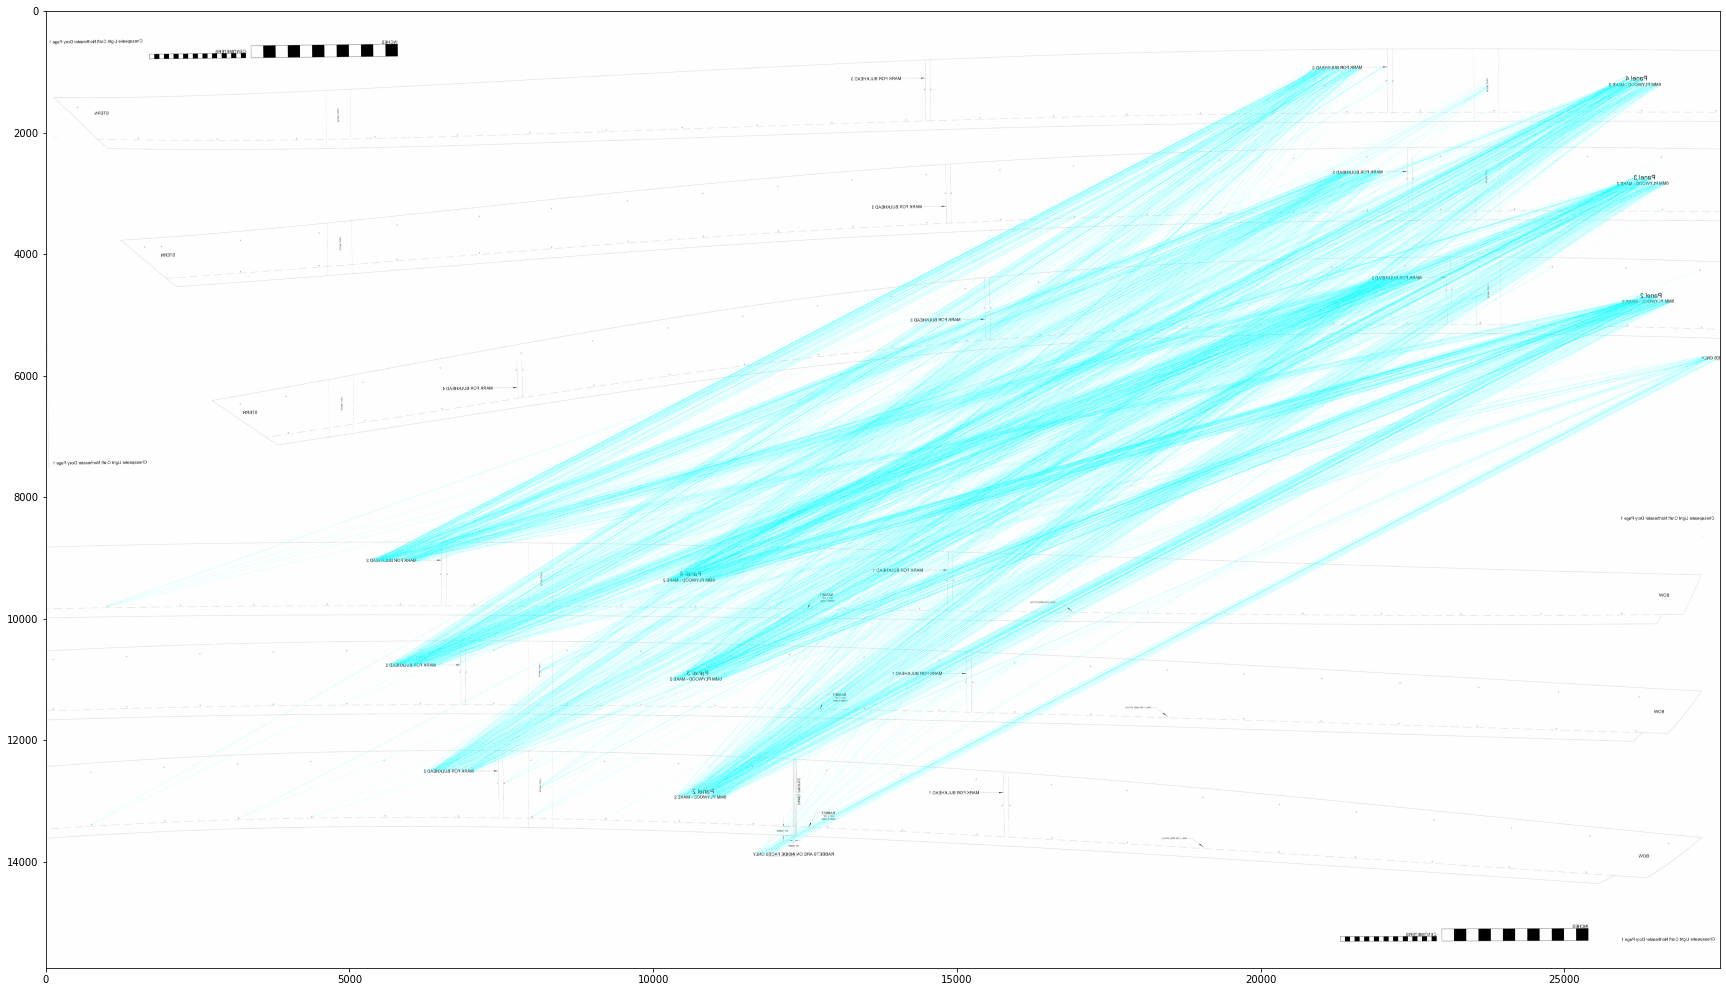

In [10]:
for_show = draw_matches(top, keypoints1, bottom, keypoints2, sound_matches)

plt.figure(figsize = (30,20))
plt.imshow(np.transpose(for_show, (1,0,2)))
plt.show()

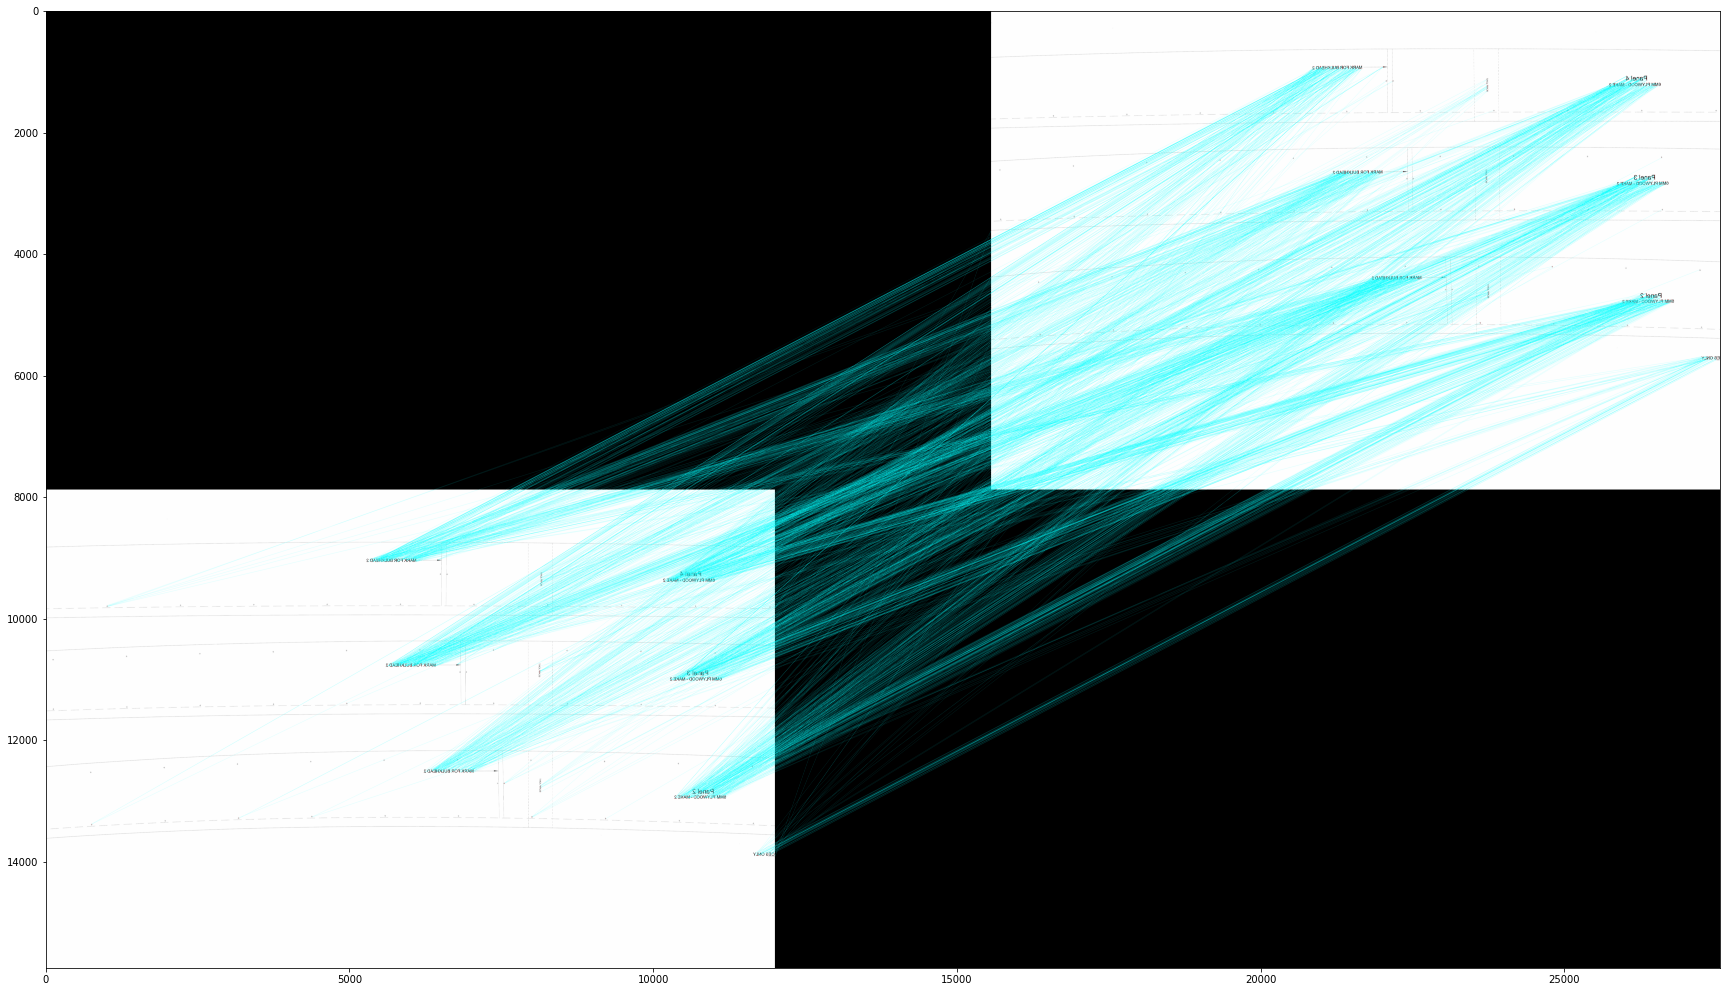

In [11]:
for_show = draw_matches(masked_top, keypoints1, masked_bottom, keypoints2, sound_matches)

plt.figure(figsize = (30,20))
plt.imshow(np.transpose(for_show, (1,0,2)))
plt.show()

c:\Users\u344260\pythonvenvs\boatBuilding\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


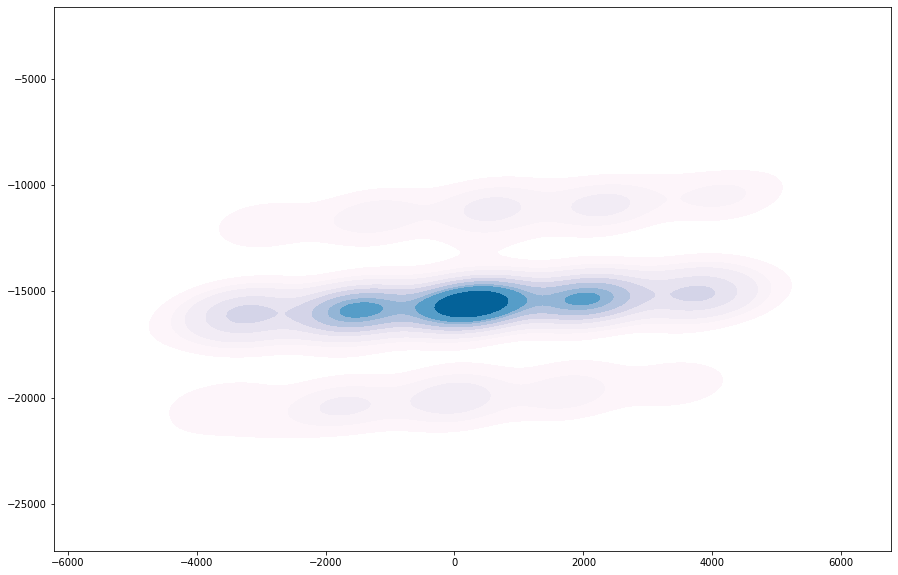

In [12]:


fig,ax = plt.subplots(figsize=(15,10))
ax = sns.kdeplot(xs,ys, shade = True, cmap = "PuBu")
# ax.patch.set_facecolor('white')
# ax.collections[0].set_alpha(0)
# ax.set_xlabel('$Y_1$', fontsize = 15)
# ax.set_ylabel('$Y_0$', fontsize = 15)
# pl.xlim(-3, 3)
# pl.ylim(-3, 3)
# pl.plot([-3, 3], [-3, 3], color = "black", linewidth = 1)
plt.show()

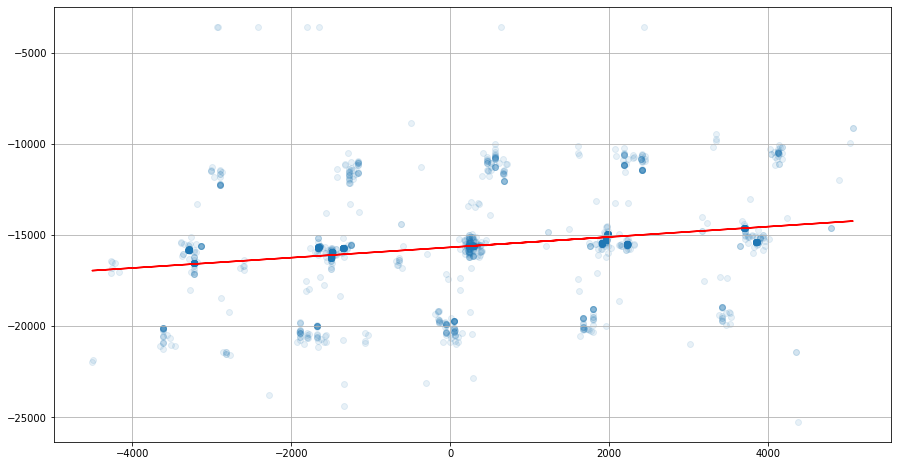

In [13]:
linreg = scipy.stats.linregress(xs, y=ys)
m = linreg.slope
c = linreg.intercept

lrx = np.array(xs)
lry = m*lrx + c

fig,ax = plt.subplots(figsize=(15,8))
ax.scatter(xs,ys, alpha=0.1)
ax.plot(lrx, lry, color='red')
plt.grid()
plt.show()

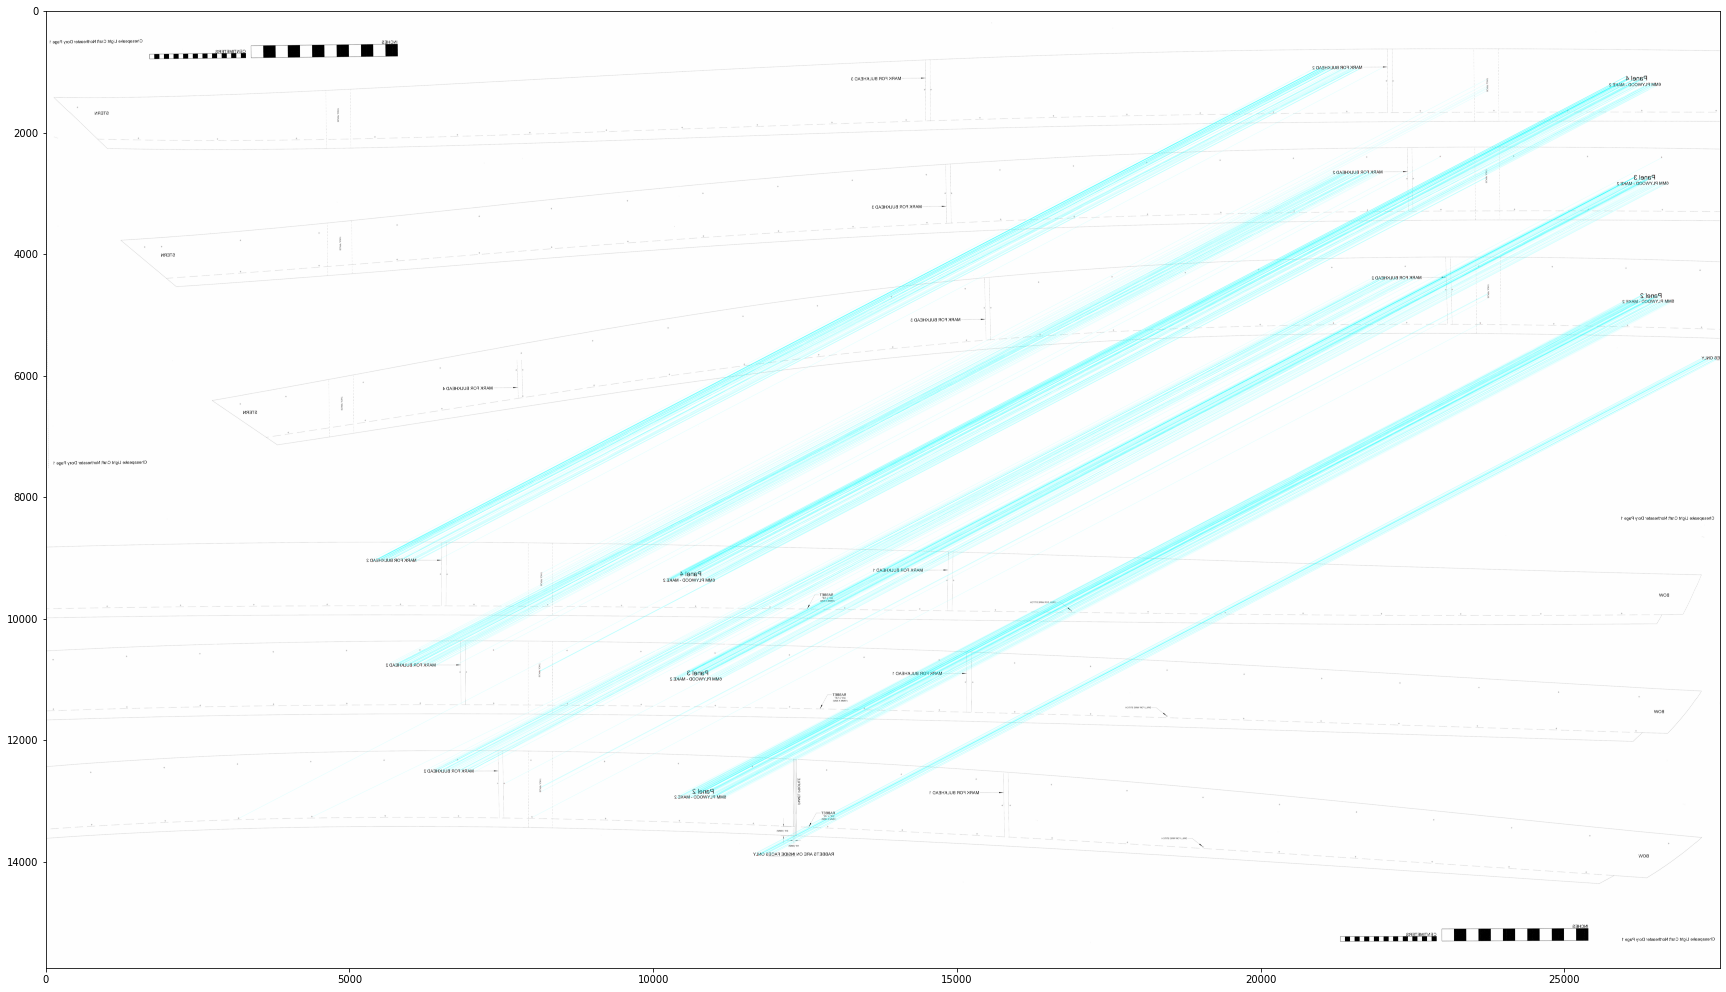

In [14]:
xs = []
ys = []
sound_matches = []

for m, n in matches:
    img1_idx = m.queryIdx
    img2_idx = m.trainIdx
    (x1, y1) = keypoints1[img1_idx].pt
    (x2, y2) = keypoints2[img2_idx].pt
    if (x2-x1 > -200) & (x2-x1 < 600) & (y2-y1 > -17000) & (y2-y1 < -14000):
        sound_matches.append(m)
        xs.append(x2-x1)
        ys.append(y2-y1)


for_show = draw_matches(top, keypoints1, bottom, keypoints2, sound_matches)

plt.figure(figsize = (30,20))
plt.imshow(np.transpose(for_show, (1,0,2)))
plt.show()

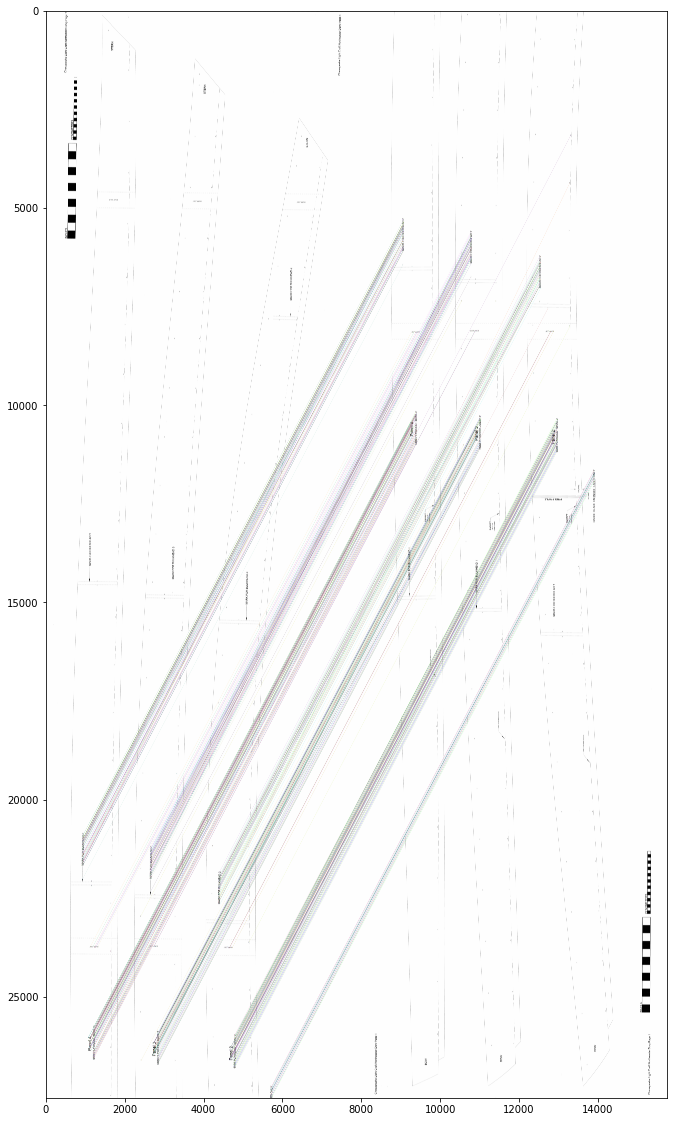

In [15]:
imMatches = cv2.drawMatches(top, keypoints1, bottom, keypoints2, sound_matches, None)

plt.figure(figsize = (30,20))
plt.imshow(imMatches)
plt.show()
# cv2.imwrite("matches.jpg", imMatches)


In [16]:
	  # Extract location of good matches
points1 = np.zeros((len(sound_matches), 2), dtype=np.float32)
points2 = np.zeros((len(sound_matches), 2), dtype=np.float32)

for i, match in enumerate(sound_matches):
    points1[i, :] = keypoints1[match.queryIdx].pt
    points2[i, :] = keypoints2[match.trainIdx].pt


In [17]:
# Find homography
h, mask = cv2.findHomography(points1, points2, cv2.RANSAC)

# Use homography
height, width, channels = bottom.shape
im1Reg = cv2.warpPerspective(top, h, (width, height))

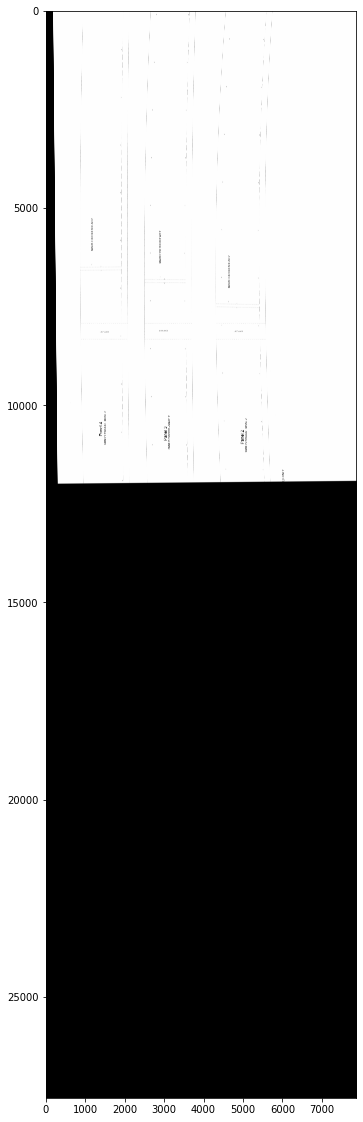

In [18]:
plt.figure(figsize = (30,20))
plt.imshow(im1Reg)
plt.show()

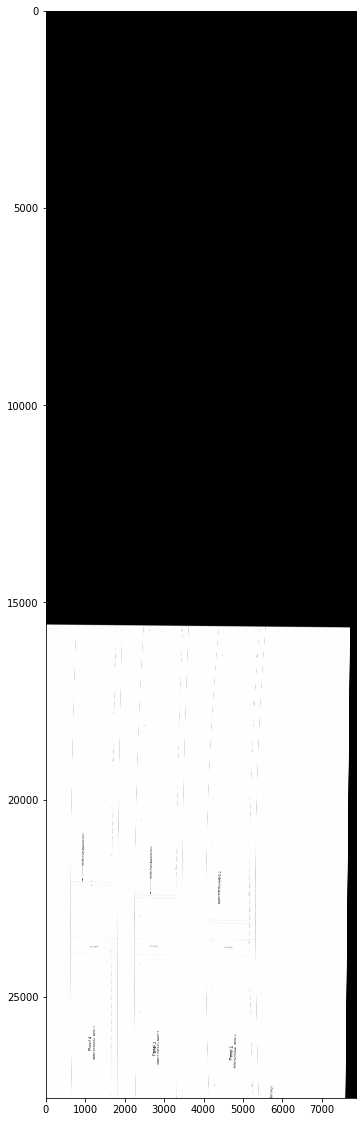

In [19]:
# Find homography
h, mask = cv2.findHomography(points2, points1, cv2.RANSAC)

# Use homography
height, width, channels = bottom.shape

im2Reg = cv2.warpPerspective(bottom, h, (width, height))
plt.figure(figsize = (30,20))
plt.imshow(im2Reg)
plt.show()

In [20]:
bottom = np.where(bottom>127, 255, 0)
top = np.where(top>127, 255, 0)

r1, g1, b1 = 0, 0, 0 # Original value
r2, g2, b2 = 0, 0, 255 # Value that we want to replace it with

red, green, blue = bottom[:,:,0], bottom[:,:,1], bottom[:,:,2]
mask = (red == r1) & (green == g1) & (blue == b1)
bottom[:,:,:3][mask] = [r2, g2, b2]

r1, g1, b1 = 0, 0, 0 # Original value
r2, g2, b2 = 255, 0, 0 # Value that we want to replace it with

red, green, blue = top[:,:,0], top[:,:,1], top[:,:,2]
mask = (red == r1) & (green == g1) & (blue == b1)
top[:,:,:3][mask] = [r2, g2, b2]




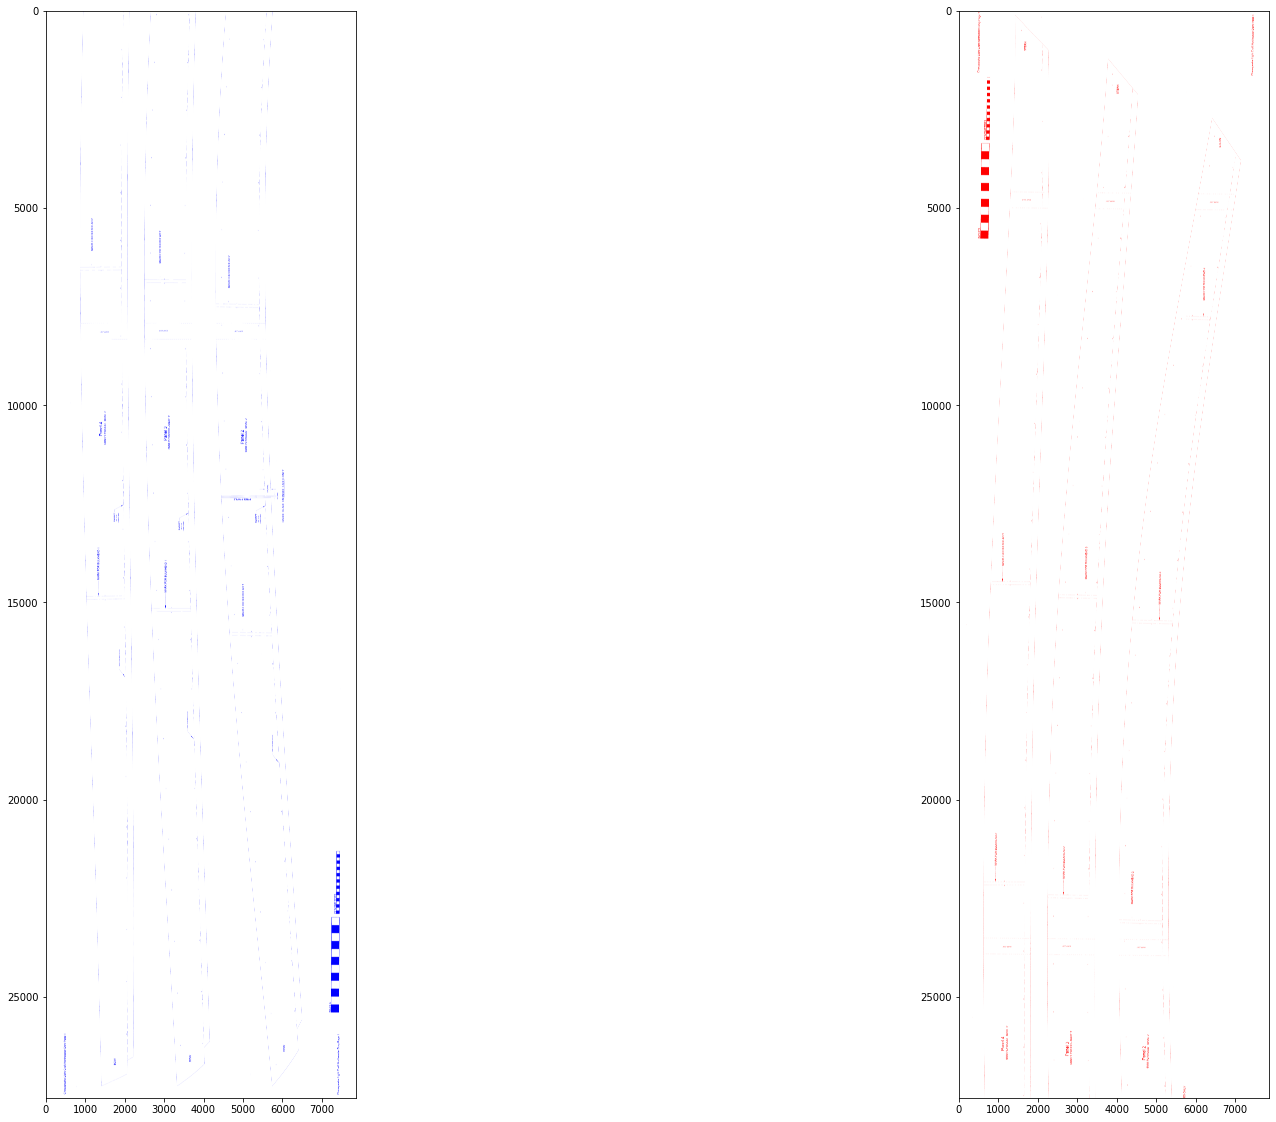

In [22]:
fig,ax = plt.subplots(1,2,figsize = (30,20))
ax[0].imshow(bottom)
ax[1].imshow(top)
plt.show()

In [27]:
top = np.uint8(top)
bottom = np.uint8(bottom)

In [28]:


# Find homography
h, mask = cv2.findHomography(points2, points1, cv2.RANSAC)

# Use homography
height = 2*top.shape[0]
width = 2*top.shape[1]

tahi = cv2.warpPerspective(bottom, h, (width, height))


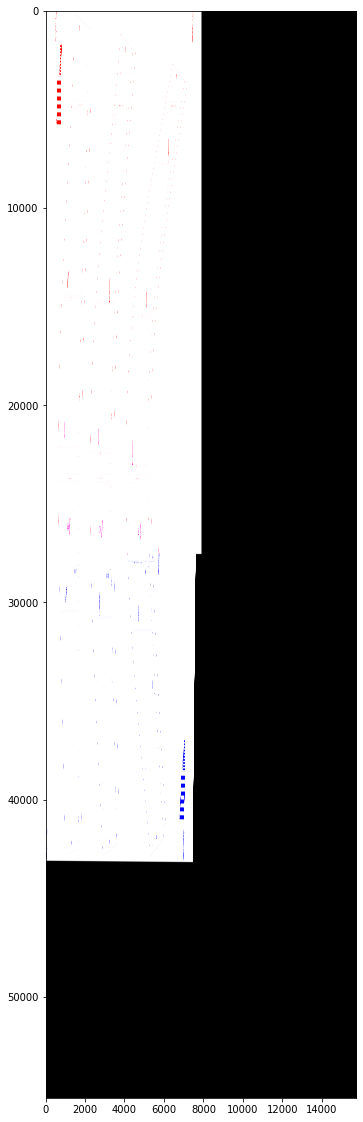

In [29]:
red, green, blue = tahi[:,:,0], tahi[:,:,1], tahi[:,:,2]

white_mask = (red == 255) & (green == 255) & (blue == 255)
blue_mask = (red == 0) & (green == 0) & (blue == 255)
black_mask = (red == 0) & (green == 0) & (blue == 0)

tahi[:top.shape[0],:top.shape[1],:] = top
tahi[:,:,2] = np.where(blue_mask, 255, tahi[:,:,2])


plt.figure(figsize = (30,20))
plt.imshow(tahi)
plt.show()


In [37]:
red, green, blue = tahi[:,:,0], tahi[:,:,1], tahi[:,:,2]

black_mask = (red == 0) & (green == 0) & (blue == 0)

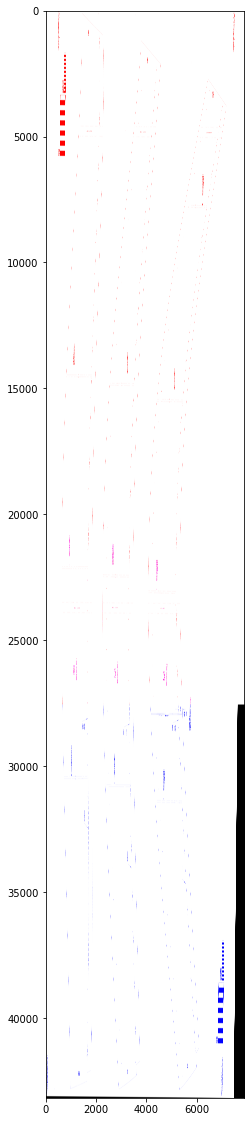

In [54]:
x_trim = sum(black_mask.sum(axis=0)<55120)
y_trim = sum(black_mask.sum(axis=1)<15750)

tahi = tahi[:y_trim,:x_trim,:]

plt.figure(figsize = (30,20))
plt.imshow(tahi)
plt.show()

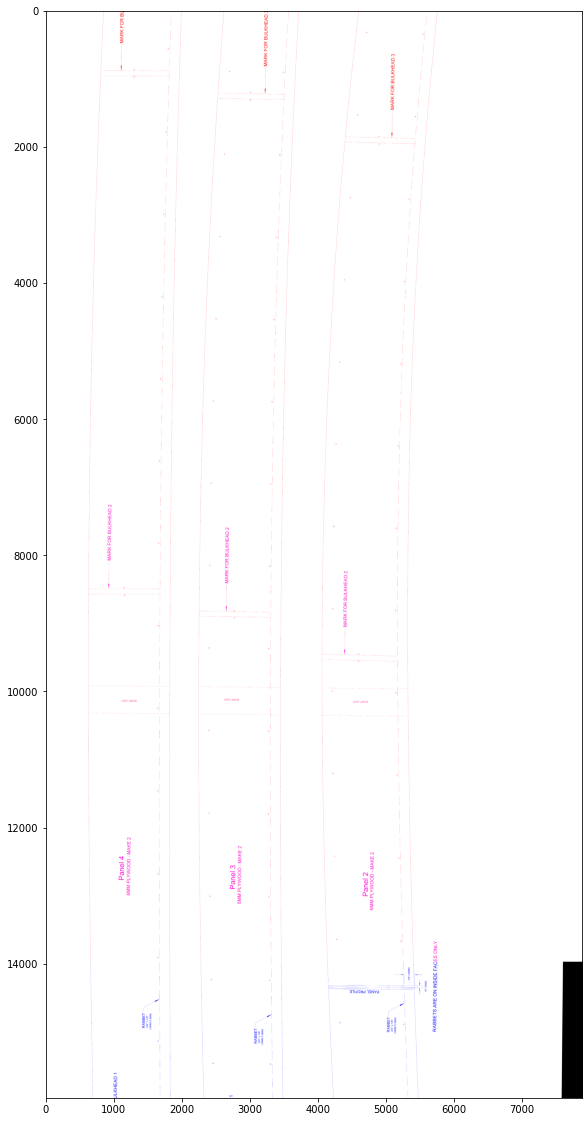

In [57]:
slice = tahi[-y-2000:top.shape[0]+2000,:,].copy()

plt.figure(figsize = (30,20))
plt.imshow(slice)
plt.show()


In [58]:
cv2.imwrite("slice.png", slice)

True

In [64]:
grayImage = cv2.cvtColor(tahi, cv2.COLOR_BGR2GRAY)
(thresh, blackAndWhiteImage) = cv2.threshold(grayImage, 127, 255, cv2.THRESH_BINARY)
cv2.imwrite("page1.png", blackAndWhiteImage)


True

In [36]:
tahi = raw_images[0].copy()
rua = np.rot90(raw_images[1],k=2).copy()

# fig,ax = plt.subplots(1,2,figsize=(30,40))
# ax[0].imshow(tahi)
# ax[1].imshow(rua)
# plt.show()

top = np.array(tahi)
bottom = np.array(rua)

overlap = 12000
top = np.array(tahi)
bottom = np.array(rua)

orb = cv2.ORB_create(nfeatures=2000, fastThreshold = 5)

# creating a masked image (I couldn't get a mask to work otherwise)
masked_top = np.copy(top)
masked_top[:-overlap,:,] = np.zeros_like(top[:-overlap,:,])

masked_bottom = np.copy(bottom)
masked_bottom[overlap:,:,] = np.zeros_like(bottom[overlap:,:,])

# Find the key points and descriptors with ORB
keypoints1, descriptors1 = orb.detectAndCompute(masked_top, None)
keypoints2, descriptors2 = orb.detectAndCompute(masked_bottom, None)

# Create a BFMatcher object.
# It will find all of the matching keypoints on two images
bf = cv2.BFMatcher_create(cv2.NORM_HAMMING)

# Find matching points
matches = bf.knnMatch(descriptors1, descriptors2, k=2)

# sound_matches
sound_matches = [a for a,b in matches]


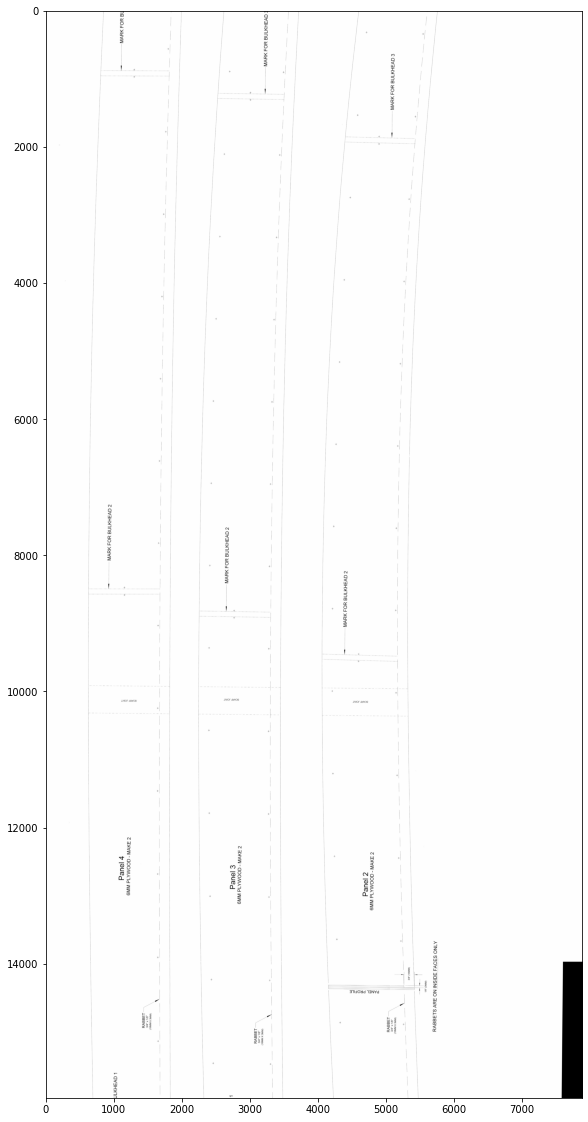

In [37]:
xs = []
ys = []
sound_matches = []

for m, n in matches:
    img1_idx = m.queryIdx
    img2_idx = m.trainIdx
    (x1, y1) = keypoints1[img1_idx].pt
    (x2, y2) = keypoints2[img2_idx].pt
    if (x2-x1 > -200) & (x2-x1 < 600) & (y2-y1 > -17000) & (y2-y1 < -14000):
        sound_matches.append(m)
        xs.append(x2-x1)
        ys.append(y2-y1)

xy = np.vstack([xs,ys])
kde = scipy.stats.gaussian_kde(xy)
density = kde(xy)
x, y = xy.T[np.argmax(density)].astype('int')
      
      # Extract location of good matches
points1 = np.zeros((len(sound_matches), 2), dtype=np.float32)
points2 = np.zeros((len(sound_matches), 2), dtype=np.float32)

for i, match in enumerate(sound_matches):
    points1[i, :] = keypoints1[match.queryIdx].pt
    points2[i, :] = keypoints2[match.trainIdx].pt


# bottom = np.where(bottom>127, 255, 0)
# top = np.where(top>127, 255, 0)

# r1, g1, b1 = 0, 0, 0 # Original value
# r2, g2, b2 = 0, 0, 0 # Value that we want to replace it with

# red, green, blue = bottom[:,:,0], bottom[:,:,1], bottom[:,:,2]
# mask = (red == r1) & (green == g1) & (blue == b1)
# bottom[:,:,:3][mask] = [r2, g2, b2]

# r1, g1, b1 = 0, 0, 0 # Original value
# r2, g2, b2 = 0, 0, 0 # Value that we want to replace it with

# red, green, blue = top[:,:,0], top[:,:,1], top[:,:,2]
# mask = (red == r1) & (green == g1) & (blue == b1)
# top[:,:,:3][mask] = [r2, g2, b2]

# top = np.uint8(top)
# bottom = np.uint8(bottom)

# Find homography
h, mask = cv2.findHomography(points2, points1, cv2.RANSAC)

# Use homography
height = 2*top.shape[0]
width = 2*top.shape[1]

tahi = cv2.warpPerspective(bottom, h, (width, height))


red, green, blue = tahi[:,:,0], tahi[:,:,1], tahi[:,:,2]

white_mask = (red == 255) & (green == 255) & (blue == 255)
blue_mask = (red == 0) & (green == 0) & (blue == 255)
black_mask = (red == 0) & (green == 0) & (blue == 0)

tahi[:top.shape[0],:top.shape[1],:] = top
tahi[:,:,2] = np.where(blue_mask, 255, tahi[:,:,2])

red, green, blue = tahi[:,:,0], tahi[:,:,1], tahi[:,:,2]

black_mask = (red == 0) & (green == 0) & (blue == 0)

x_trim = sum(black_mask.sum(axis=0)<55120)
y_trim = sum(black_mask.sum(axis=1)<15750)

tahi = tahi[:y_trim,:x_trim,:]

slice = tahi[-y-2000:top.shape[0]+2000,:,].copy()

plt.figure(figsize = (30,20))
plt.imshow(slice)
plt.show()


In [38]:
cv2.imwrite("redo_page_1.png", tahi)

True

In [30]:
tahi = raw_images[2].copy()
rua = np.rot90(raw_images[3],k=2).copy()

# fig,ax = plt.subplots(1,2,figsize=(30,40))
# ax[0].imshow(tahi)
# ax[1].imshow(rua)
# plt.show()

top = np.array(tahi)
bottom = np.array(rua)

overlap = 12000
top = np.array(tahi)
bottom = np.array(rua)

orb = cv2.ORB_create(nfeatures=2000, fastThreshold = 5)

# creating a masked image (I couldn't get a mask to work otherwise)
masked_top = np.copy(top)
masked_top[:-overlap,:,] = np.zeros_like(top[:-overlap,:,])

masked_bottom = np.copy(bottom)
masked_bottom[overlap:,:,] = np.zeros_like(bottom[overlap:,:,])

# Find the key points and descriptors with ORB
keypoints1, descriptors1 = orb.detectAndCompute(masked_top, None)
keypoints2, descriptors2 = orb.detectAndCompute(masked_bottom, None)

# Create a BFMatcher object.
# It will find all of the matching keypoints on two images
bf = cv2.BFMatcher_create(cv2.NORM_HAMMING)

# Find matching points
matches = bf.knnMatch(descriptors1, descriptors2, k=2)

# sound_matches
sound_matches = [a for a,b in matches]


In [32]:
# plt.figure(figsize = (30,20))
# plt.imshow(top)
# plt.show()

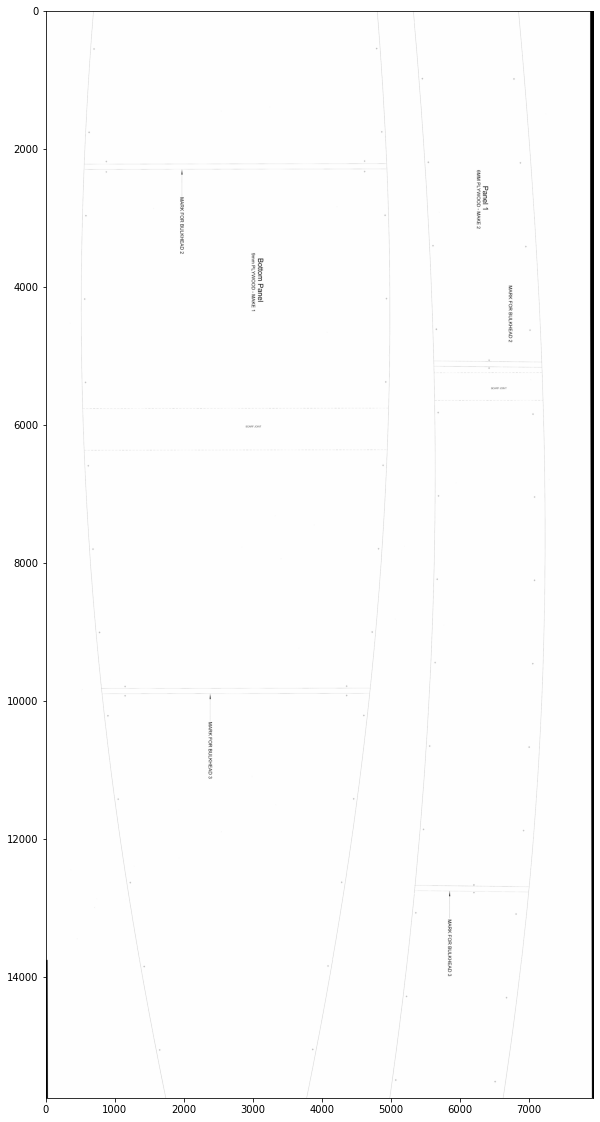

In [33]:
xs = []
ys = []
sound_matches = []

for m, n in matches:
    img1_idx = m.queryIdx
    img2_idx = m.trainIdx
    (x1, y1) = keypoints1[img1_idx].pt
    (x2, y2) = keypoints2[img2_idx].pt
    if (x2-x1 > -200) & (x2-x1 < 600) & (y2-y1 > -17000) & (y2-y1 < -14000):
        sound_matches.append(m)
        xs.append(x2-x1)
        ys.append(y2-y1)

xy = np.vstack([xs,ys])
kde = scipy.stats.gaussian_kde(xy)
density = kde(xy)
x, y = xy.T[np.argmax(density)].astype('int')
      
      # Extract location of good matches
points1 = np.zeros((len(sound_matches), 2), dtype=np.float32)
points2 = np.zeros((len(sound_matches), 2), dtype=np.float32)

for i, match in enumerate(sound_matches):
    points1[i, :] = keypoints1[match.queryIdx].pt
    points2[i, :] = keypoints2[match.trainIdx].pt


# bottom = np.where(bottom>127, 255, 0)
# top = np.where(top>127, 255, 0)

# r1, g1, b1 = 0, 0, 0 # Original value
# r2, g2, b2 = 0, 0, 0 # Value that we want to replace it with

# red, green, blue = bottom[:,:,0], bottom[:,:,1], bottom[:,:,2]
# mask = (red == r1) & (green == g1) & (blue == b1)
# bottom[:,:,:3][mask] = [r2, g2, b2]

# r1, g1, b1 = 0, 0, 0 # Original value
# r2, g2, b2 = 0, 0, 0 # Value that we want to replace it with

# red, green, blue = top[:,:,0], top[:,:,1], top[:,:,2]
# mask = (red == r1) & (green == g1) & (blue == b1)
# top[:,:,:3][mask] = [r2, g2, b2]

# top = np.uint8(top)
# bottom = np.uint8(bottom)

# Find homography
h, mask = cv2.findHomography(points2, points1, cv2.RANSAC)

# Use homography
height = 2*top.shape[0]
width = 2*top.shape[1]

tahi = cv2.warpPerspective(bottom, h, (width, height))


red, green, blue = tahi[:,:,0], tahi[:,:,1], tahi[:,:,2]

white_mask = (red == 255) & (green == 255) & (blue == 255)
blue_mask = (red == 0) & (green == 0) & (blue == 255)
black_mask = (red == 0) & (green == 0) & (blue == 0)

tahi[:top.shape[0],:top.shape[1],:] = top
tahi[:,:,2] = np.where(blue_mask, 255, tahi[:,:,2])

red, green, blue = tahi[:,:,0], tahi[:,:,1], tahi[:,:,2]

black_mask = (red == 0) & (green == 0) & (blue == 0)

x_trim = sum(black_mask.sum(axis=0)<55120)
y_trim = sum(black_mask.sum(axis=1)<15750)

tahi = tahi[:y_trim,:x_trim,:]

slice = tahi[-y-2000:top.shape[0]+2000,:,].copy()

plt.figure(figsize = (30,20))
plt.imshow(slice)
plt.show()


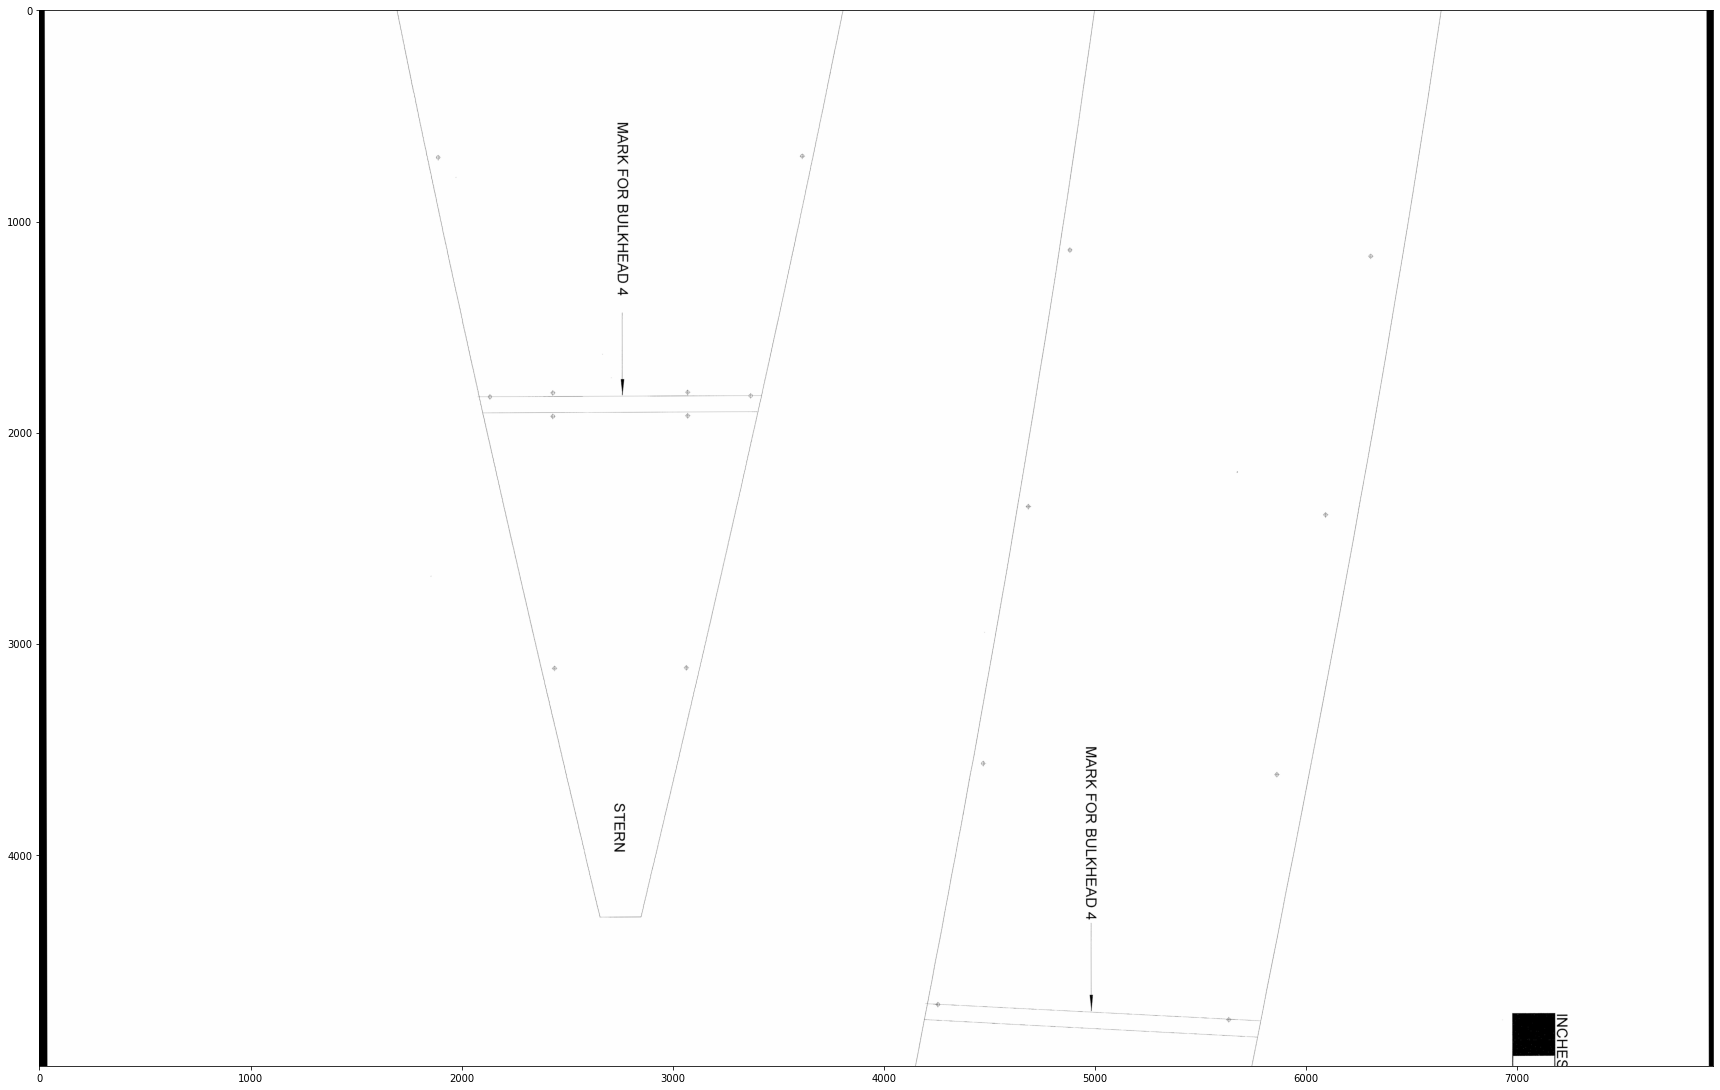

In [34]:
# slice = tahi[-5000:,:,].copy()
slice = tahi[-14000:-9000,:,].copy()

plt.figure(figsize = (30,20))
plt.imshow(slice)
plt.show()

In [35]:
cv2.imwrite("redo_page_2.png", tahi)

True

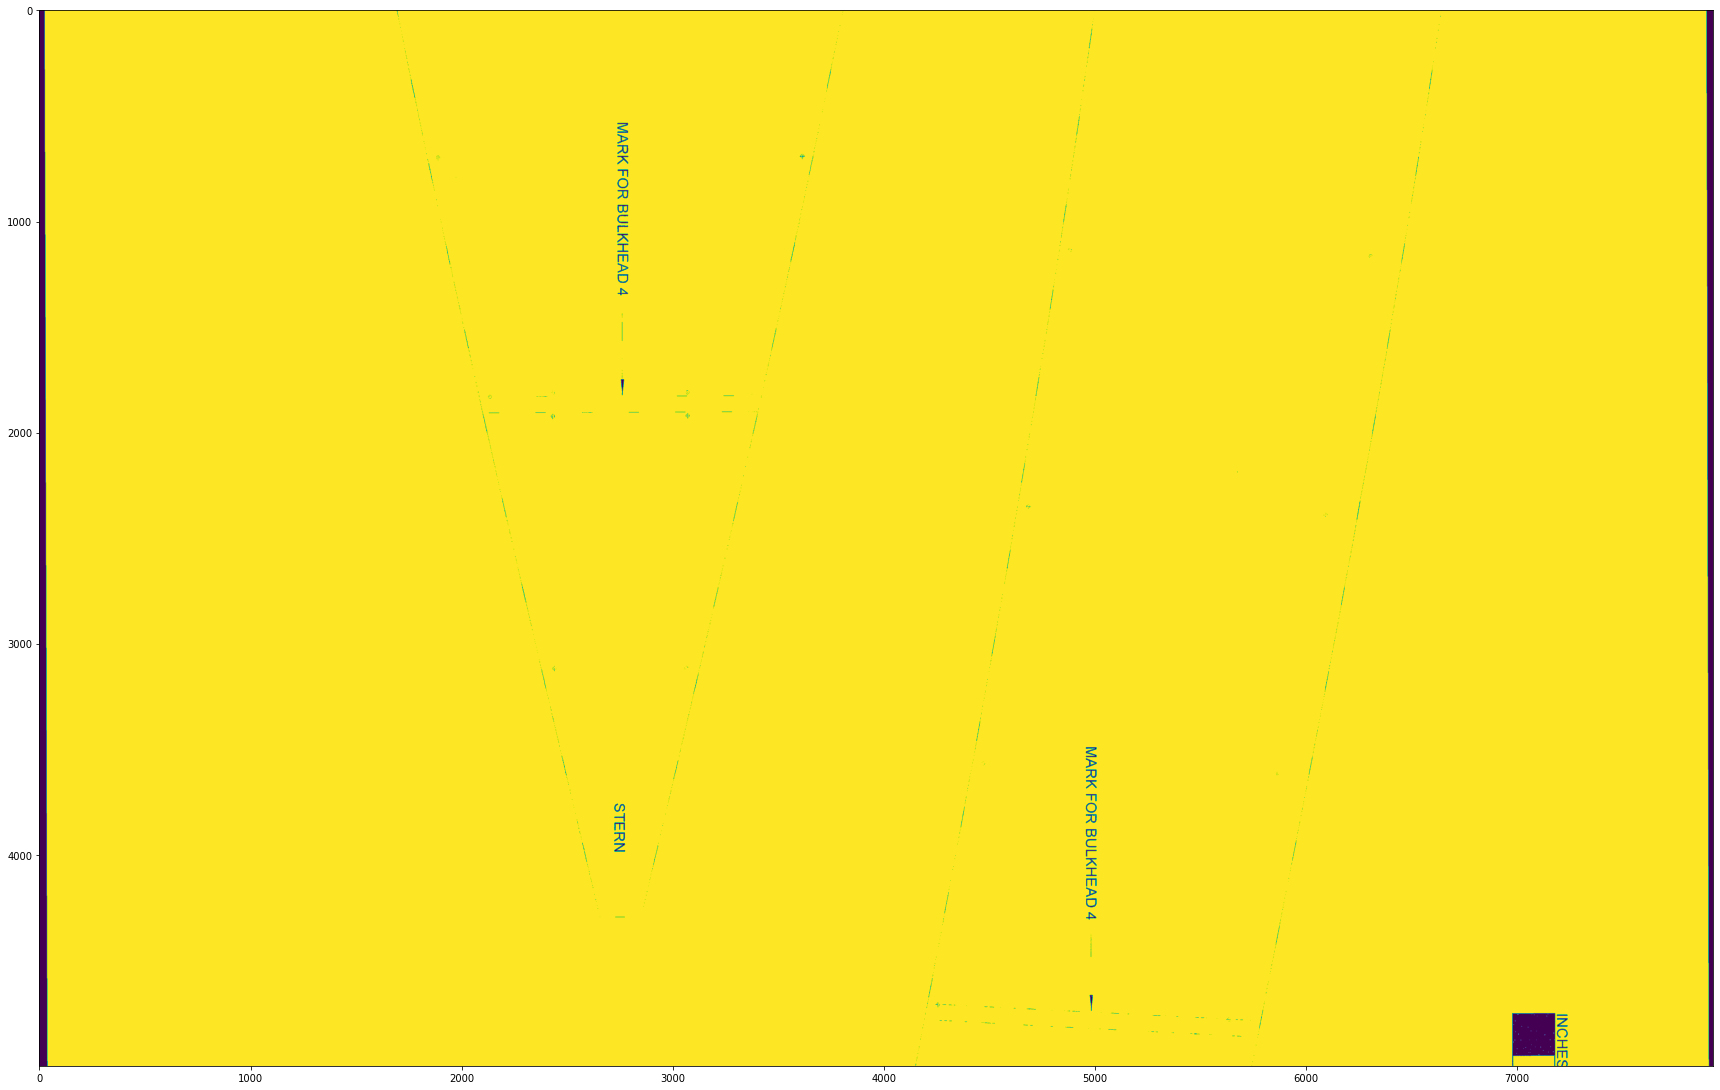

In [13]:
# # cv2.imwrite("slice_page_2.png", slice)

# grayImage = cv2.cvtColor(tahi, cv2.COLOR_BGR2GRAY)
# (thresh, blackAndWhiteImage) = cv2.threshold(grayImage, 95, 255, cv2.THRESH_BINARY)
# # cv2.imwrite("page2.png", blackAndWhiteImage)

# slice = blackAndWhiteImage[-14000:-9000,:,].copy()

# plt.figure(figsize = (30,20))
# plt.imshow(slice)
# plt.show()

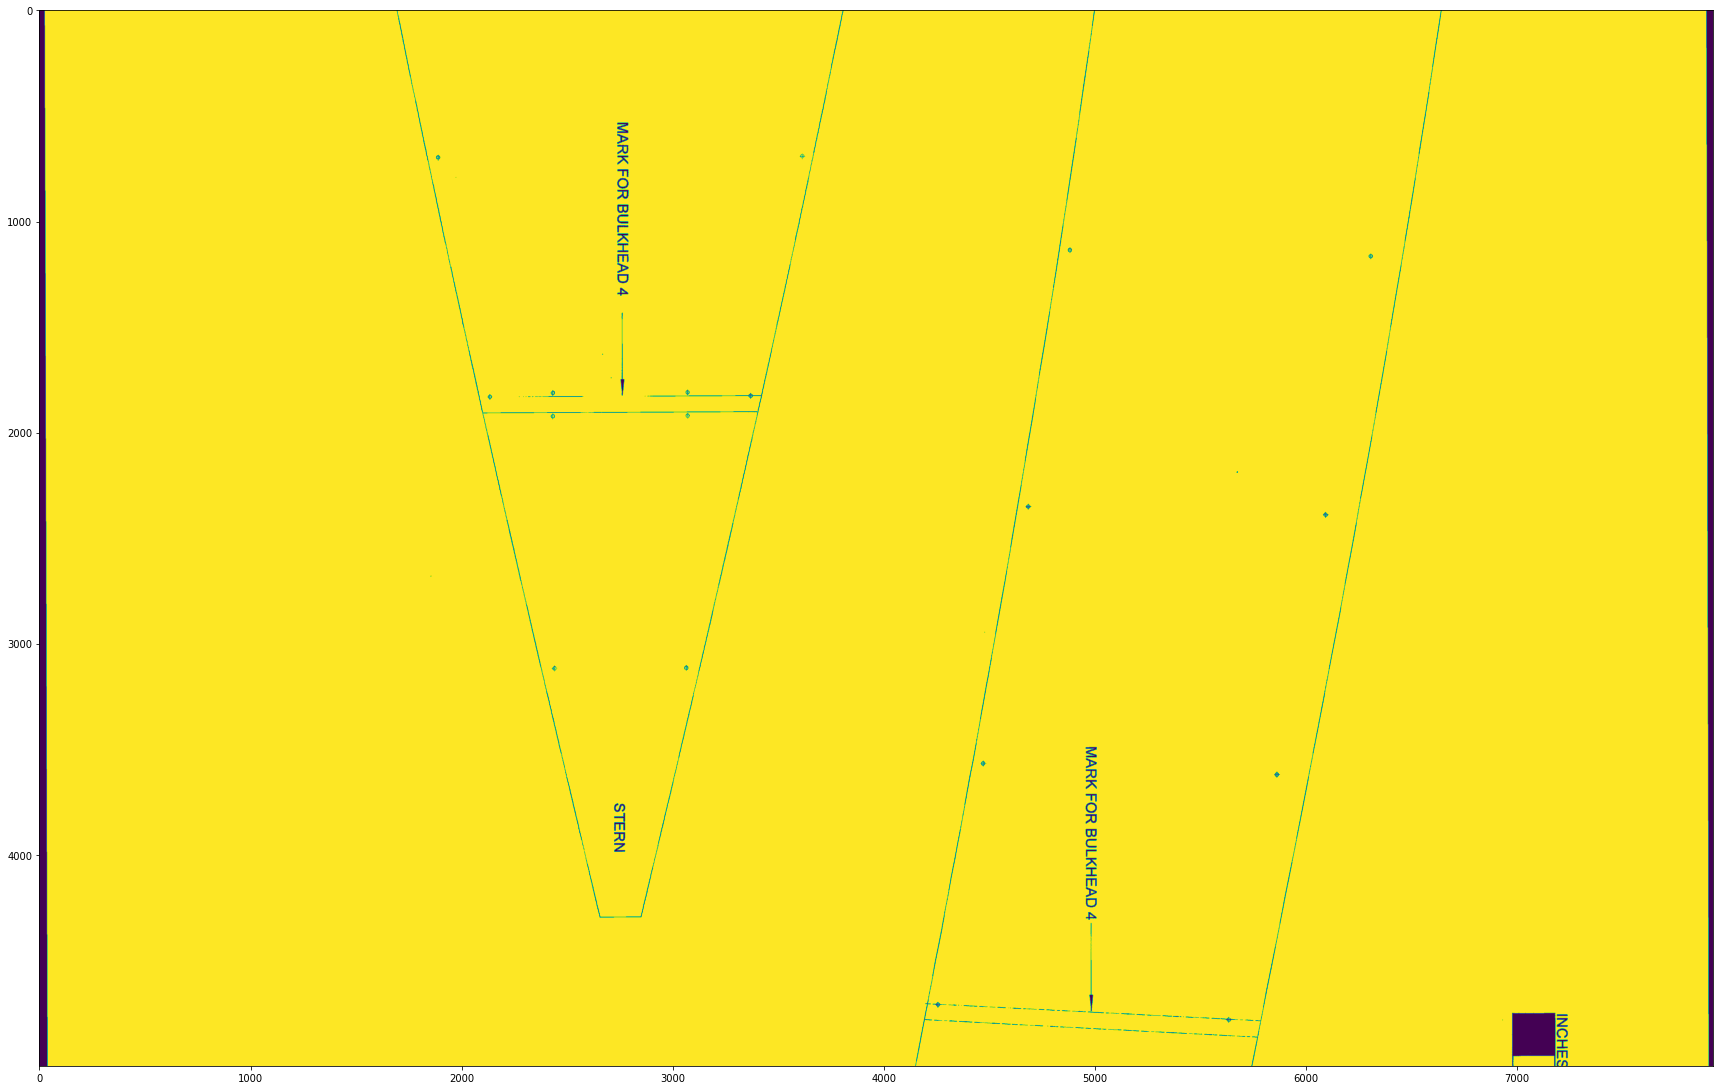

In [15]:
# cv2.imwrite("slice_page_2.png", slice)

grayImage = cv2.cvtColor(tahi, cv2.COLOR_BGR2GRAY)
(thresh, blackAndWhiteImage) = cv2.threshold(grayImage, 230, 255, cv2.THRESH_BINARY)
# cv2.imwrite("page2.png", blackAndWhiteImage)

slice = blackAndWhiteImage[-14000:-9000,:,].copy()

plt.figure(figsize = (30,20))
plt.imshow(slice)
plt.show()

In [22]:
pix, counts = np.unique(tahi, return_counts=True)

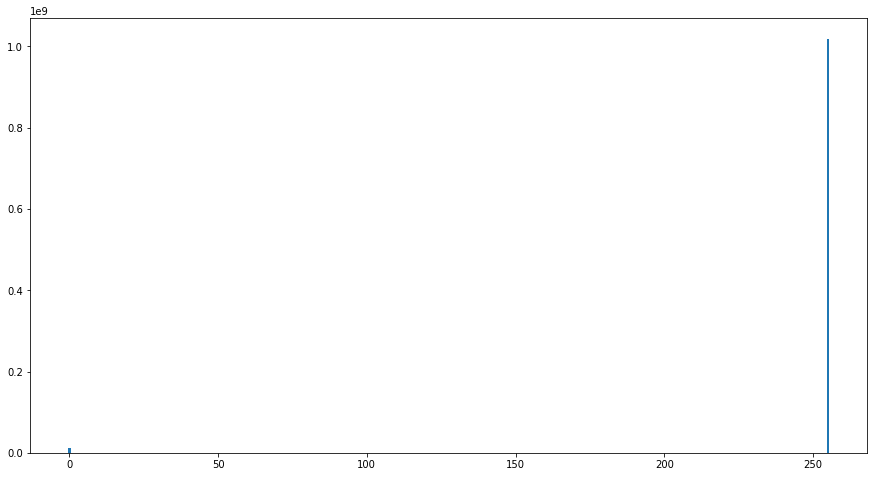

In [23]:

fig, ax = plt.subplots(figsize=(15,8))
ax.bar(pix, counts)
plt.show()


In [24]:
pix

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [25]:
counts

array([  11356282,       2246,       2444,       3164,       3550,
             3054,       3452,       4180,      33434,       2342,
             2902,       2020,       2698,       2682,       2630,
             2672,      34313,       1708,       1722,       2382,
             1990,       2218,       2882,       1870,      33492,
             1896,       1762,       2152,       1650,       1236,
             2768,       2858,      33267,       1286,       1658,
             1278,       2184,       1778,       2344,       1670,
            33989,        430,       2502,        832,       1362,
             2574,       1550,       1914,      33188,       2028,
              845,        932,       2844,       1130,       2184,
             1134,      33900,        900,       1726,        520,
             2854,       1014,       1812,       1794,      33022,
             1296,       1268,       2522,       2010,        862,
             1392,       1274,      34520,        736,       1

In [40]:
tahi = raw_images[4].copy()
rua = np.rot90(raw_images[5],k=2).copy()

# fig,ax = plt.subplots(1,2,figsize=(30,40))
# ax[0].imshow(tahi)
# ax[1].imshow(rua)
# plt.show()

top = np.array(tahi)
bottom = np.array(rua)

overlap = 12000
top = np.array(tahi)
bottom = np.array(rua)

orb = cv2.ORB_create(nfeatures=2000, fastThreshold = 5)

# creating a masked image (I couldn't get a mask to work otherwise)
masked_top = np.copy(top)
masked_top[:-overlap,:,] = np.zeros_like(top[:-overlap,:,])

masked_bottom = np.copy(bottom)
masked_bottom[overlap:,:,] = np.zeros_like(bottom[overlap:,:,])

# Find the key points and descriptors with ORB
keypoints1, descriptors1 = orb.detectAndCompute(masked_top, None)
keypoints2, descriptors2 = orb.detectAndCompute(masked_bottom, None)

# Create a BFMatcher object.
# It will find all of the matching keypoints on two images
bf = cv2.BFMatcher_create(cv2.NORM_HAMMING)

# Find matching points
matches = bf.knnMatch(descriptors1, descriptors2, k=2)

# sound_matches
sound_matches = [a for a,b in matches]


xs = []
ys = []
sound_matches = []

for m, n in matches:
    img1_idx = m.queryIdx
    img2_idx = m.trainIdx
    (x1, y1) = keypoints1[img1_idx].pt
    (x2, y2) = keypoints2[img2_idx].pt
    if (x2-x1 > -200) & (x2-x1 < 600) & (y2-y1 > -17000) & (y2-y1 < -14000):
        sound_matches.append(m)
        xs.append(x2-x1)
        ys.append(y2-y1)

xy = np.vstack([xs,ys])
kde = scipy.stats.gaussian_kde(xy)
density = kde(xy)
x, y = xy.T[np.argmax(density)].astype('int')
      
      # Extract location of good matches
points1 = np.zeros((len(sound_matches), 2), dtype=np.float32)
points2 = np.zeros((len(sound_matches), 2), dtype=np.float32)

for i, match in enumerate(sound_matches):
    points1[i, :] = keypoints1[match.queryIdx].pt
    points2[i, :] = keypoints2[match.trainIdx].pt


# bottom = np.where(bottom>127, 255, 0)
# top = np.where(top>127, 255, 0)

# r1, g1, b1 = 0, 0, 0 # Original value
# r2, g2, b2 = 0, 0, 255 # Value that we want to replace it with

# red, green, blue = bottom[:,:,0], bottom[:,:,1], bottom[:,:,2]
# mask = (red == r1) & (green == g1) & (blue == b1)
# bottom[:,:,:3][mask] = [r2, g2, b2]

# r1, g1, b1 = 0, 0, 0 # Original value
# r2, g2, b2 = 255, 0, 0 # Value that we want to replace it with

# red, green, blue = top[:,:,0], top[:,:,1], top[:,:,2]
# mask = (red == r1) & (green == g1) & (blue == b1)
# top[:,:,:3][mask] = [r2, g2, b2]

# top = np.uint8(top)
# bottom = np.uint8(bottom)

# Find homography
h, mask = cv2.findHomography(points2, points1, cv2.RANSAC)

# Use homography
height = 2*top.shape[0]
width = 2*top.shape[1]

tahi = cv2.warpPerspective(bottom, h, (width, height))


red, green, blue = tahi[:,:,0], tahi[:,:,1], tahi[:,:,2]

white_mask = (red == 255) & (green == 255) & (blue == 255)
blue_mask = (red == 0) & (green == 0) & (blue == 255)
black_mask = (red == 0) & (green == 0) & (blue == 0)

tahi[:top.shape[0],:top.shape[1],:] = top
tahi[:,:,2] = np.where(blue_mask, 255, tahi[:,:,2])

red, green, blue = tahi[:,:,0], tahi[:,:,1], tahi[:,:,2]

black_mask = (red == 0) & (green == 0) & (blue == 0)

x_trim = sum(black_mask.sum(axis=0)<55120)
y_trim = sum(black_mask.sum(axis=1)<15750)

tahi = tahi[:y_trim,:x_trim,:]

slice = tahi[-y-2000:top.shape[0]+2000,:,].copy()

# cv2.imwrite("slice_page_3.png", slice)

grayImage = cv2.cvtColor(tahi, cv2.COLOR_BGR2GRAY)
(thresh, blackAndWhiteImage) = cv2.threshold(grayImage, 127, 255, cv2.THRESH_BINARY)
cv2.imwrite("redo_page_3.png", tahi)

True